In [1]:
# Import libraries
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
# NLTK VADER for sentiment analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

# Download the VADER lexicon
nltk.download('vader_lexicon')

finwiz_url = 'https://finviz.com/quote.ashx?t='

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [5]:
news_tables = {}
tickers = ['INFY', 'WIT']

for ticker in tickers:
    url = finwiz_url + ticker
    req = Request(url=url,headers={'User-Agent': 'Mozilla/5.0 (Windows NT 6.1; WOW64; rv:20.0) Gecko/20100101 Firefox/20.0'})
    response = urlopen(req)
    # Read the contents of the file into 'html'
    html = BeautifulSoup(response)
    # Find 'news-table' in the Soup and load it into 'news_table'
    news_table = html.find(id='news-table')
    # Add the table to our dictionary
    news_tables[ticker] = news_table

In [7]:
# Read one single day of headlines for 'AMZN'
amzn = news_tables['INFY']
# Get all the table rows tagged in HTML with <tr> into 'amzn_tr'
amzn_tr = amzn.findAll('tr')

for i, table_row in enumerate(amzn_tr):
    # Read the text of the element 'a' into 'link_text'
    a_text = table_row.a.text
    # Read the text of the element 'td' into 'data_text'
    td_text = table_row.td.text
    # Print the contents of 'link_text' and 'data_text'
    print(a_text)
    print(td_text)
    # Exit after printing 4 rows of data
    if i == 3:
        break

Infosys Limited (NYSE:INFY): A Bearish Investment Perspective

            Mar-06-25 06:57PM
        
Infosys Limited (INFY) Enhances AI Governance with Launch of Open-Source Responsible AI Toolkit

            Mar-02-25 07:50PM
        
Infosys Launches Open-Source Responsible AI Toolkit to Enhance Trust and Transparency in AI

            Feb-26-25 04:57AM
        
Infosys, Lufthansa Group, and Lufthansa Systems Collaborate to Accelerate Digital Innovation in the Aviation Industry

            Feb-18-25 05:16AM
        


<ipython-input-7-95cfc0afad0c>:4: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  amzn_tr = amzn.findAll('tr')


In [8]:
parsed_news = []

# Iterate through the news
for file_name, news_table in news_tables.items():
    # Iterate through all tr tags in 'news_table'
    for x in news_table.findAll('tr'):
        # read the text from each tr tag into text
        # get text from a only
        # Check if 'a' tag exists before accessing it
        if x.a:  # This checks if x.a is not None
            text = x.a.get_text()
            # splite text in the td tag into a list
            date_scrape = x.td.text.split()
            # if the length of 'date_scrape' is 1, load 'time' as the only element

            if len(date_scrape) == 1:
                time = date_scrape[0]

            # else load 'date' as the 1st element and 'time' as the second
            else:
                date = date_scrape[0]
                time = date_scrape[1]
            # Extract the ticker from the file name, get the string up to the 1st '_'
            ticker = file_name.split('_')[0]

            # Append ticker, date, time and headline as a list to the 'parsed_news' list
            parsed_news.append([ticker, date, time, text])

parsed_news

<ipython-input-8-f6fecb2cff5a>:6: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  for x in news_table.findAll('tr'):


[['INFY',
  'Mar-06-25',
  '06:57PM',
  'Infosys Limited (NYSE:INFY): A Bearish Investment Perspective'],
 ['INFY',
  'Mar-02-25',
  '07:50PM',
  'Infosys Limited (INFY) Enhances AI Governance with Launch of Open-Source Responsible AI Toolkit'],
 ['INFY',
  'Feb-26-25',
  '04:57AM',
  'Infosys Launches Open-Source Responsible AI Toolkit to Enhance Trust and Transparency in AI'],
 ['INFY',
  'Feb-18-25',
  '05:16AM',
  'Infosys, Lufthansa Group, and Lufthansa Systems Collaborate to Accelerate Digital Innovation in the Aviation Industry'],
 ['INFY',
  'Jan-30-25',
  '01:43PM',
  'Infosys Limited (INFY) Expands Partnership with Siemens to Enhance Digital Learning with Generative AI'],
 ['INFY',
  'Jan-30-25',
  '07:29AM',
  'Infosys, Siemens to advance digital learning with generative AI'],
 ['INFY',
  'Jan-29-25',
  '12:03PM',
  'DeepSeek AI breakthrough to benefit Indian IT stocks, Bernstein says'],
 ['INFY',
  'Jan-29-25',
  '05:25AM',
  'Infosys and Siemens AG to Accelerate Digital Le

In [14]:
# Instantiate the sentiment intensity analyzer
vader = SentimentIntensityAnalyzer()

# Set column names
columns = ['ticker', 'date', 'time', 'headline']

# Convert the parsed_news list into a DataFrame called 'parsed_and_scored_news'
parsed_and_scored_news = pd.DataFrame(parsed_news, columns=columns)

# Iterate through the headlines and get the polarity scores using vader
scores = parsed_and_scored_news['headline'].apply(vader.polarity_scores).tolist()

# Convert the 'scores' list of dicts into a DataFrame
scores_df = pd.DataFrame(scores)

# Join the DataFrames of the news and the list of dicts
parsed_and_scored_news = parsed_and_scored_news.join(scores_df, rsuffix='_right')

# Convert the date column from string to datetime, handling 'Today' and similar values
# Replace 'Today', 'Yesterday' etc with current date
# Assuming if date is not in the format like 'Mar-01-25', it's 'Today'
import datetime
today = datetime.date.today()
parsed_and_scored_news['date'] = parsed_and_scored_news['date'].apply(
    lambda x: today if not (len(x) == 9 and x[3] == '-' and x[6] == '-') else x
)
parsed_and_scored_news['date'] = pd.to_datetime(parsed_and_scored_news.date).dt.date

parsed_and_scored_news.head()
parsed_and_scored_news.tail()



<ipython-input-14-638c68b32fc8>:27: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  parsed_and_scored_news['date'] = pd.to_datetime(parsed_and_scored_news.date).dt.date


,ticker,date,time,headline,neg,neu,pos,compound
195,WIT,2023-11-07,12:15AM,India's Wipro asks employees to work from offi...,0.000,1.000,0.0,0.0000
196,WIT,2023-10-19,08:23PM,Analyst Report: Wipro Limited,0.388,0.612,0.0,-0.2263
197,WIT,2023-10-19,09:00AM,Wipro Limited (NYSE:WIT) Q2 2024 Earnings Call...,0.213,0.787,0.0,-0.2263
198,WIT,2023-10-19,07:59AM,India's Cyient beats Q2 revenue estimates on s...,0.143,0.857,0.0,-0.1280
199,WIT,2023-10-18,11:45PM,"India's Wipro slides, weighs on IT peers, on w...",0.225,0.775,0.0,-0.4404


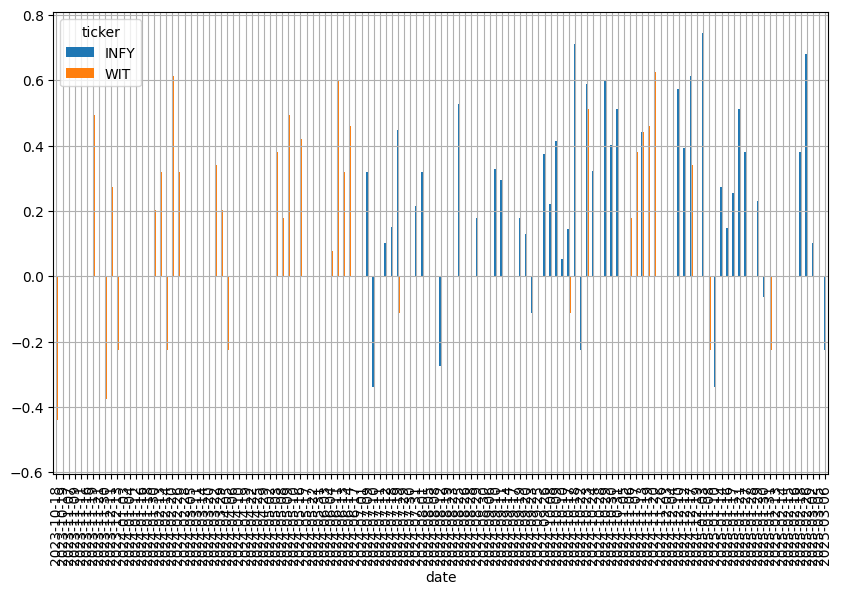

In [10]:
plt.rcParams['figure.figsize'] = [10, 6]

# Group by date and ticker columns from scored_news and calculate the mean
# Specify numeric_only=True to only calculate the mean of numeric columns
mean_scores = parsed_and_scored_news.groupby(['ticker','date']).mean(numeric_only=True)

# Unstack the column ticker
mean_scores = mean_scores.unstack()

# Get the cross-section of compound in the 'columns' axis
mean_scores = mean_scores.xs('compound', axis="columns").transpose()

# Plot a bar chart with pandas
mean_scores.plot(kind = 'bar')
plt.grid()

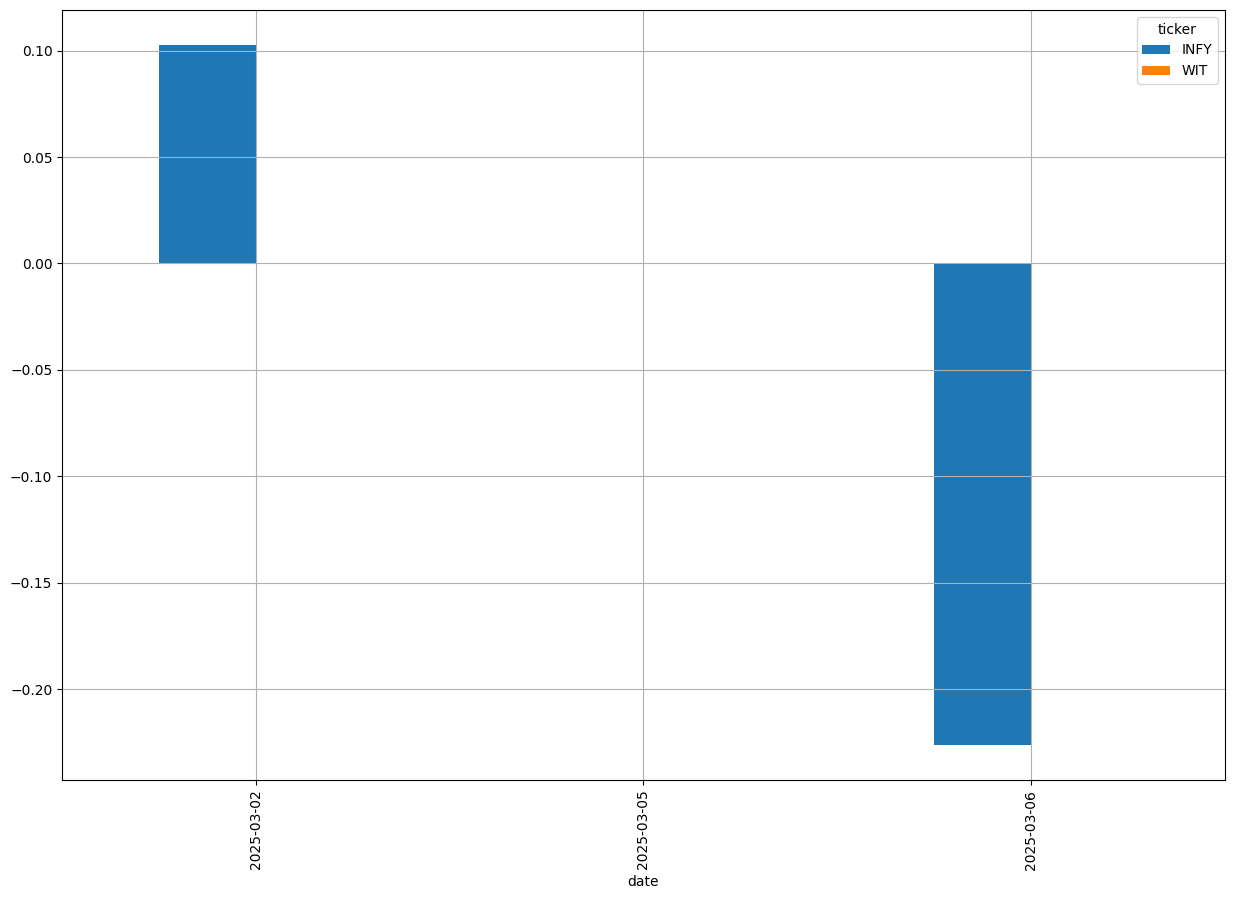

In [24]:
import datetime
import matplotlib.pyplot as plt
import pandas as pd



# Filter data for the last week
today = datetime.date.today()
one_week_ago = today - datetime.timedelta(days=7)
last_week_data = parsed_and_scored_news[
    parsed_and_scored_news['date'] >= one_week_ago
]

# Set plot size
plt.rcParams['figure.figsize'] = [15, 10]

# Calculate mean scores for the last week
mean_scores = last_week_data.groupby(['ticker', 'date']).mean(numeric_only=True)

# Reshape data for plotting
mean_scores = mean_scores.unstack()
mean_scores = mean_scores.xs('compound', axis="columns").transpose()

#Create the bar chart
mean_scores.plot(kind='bar')
plt.grid()
plt.show()